In [1]:
import sys
sys.path.append('../..')

In [2]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns
import torch.nn.functional as F

/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "serif"
})
plt.rcParams.update({
    'text.latex.preamble':r"\usepackage{amsmath}"+"\n"+r"\usepackage{bm}"
})

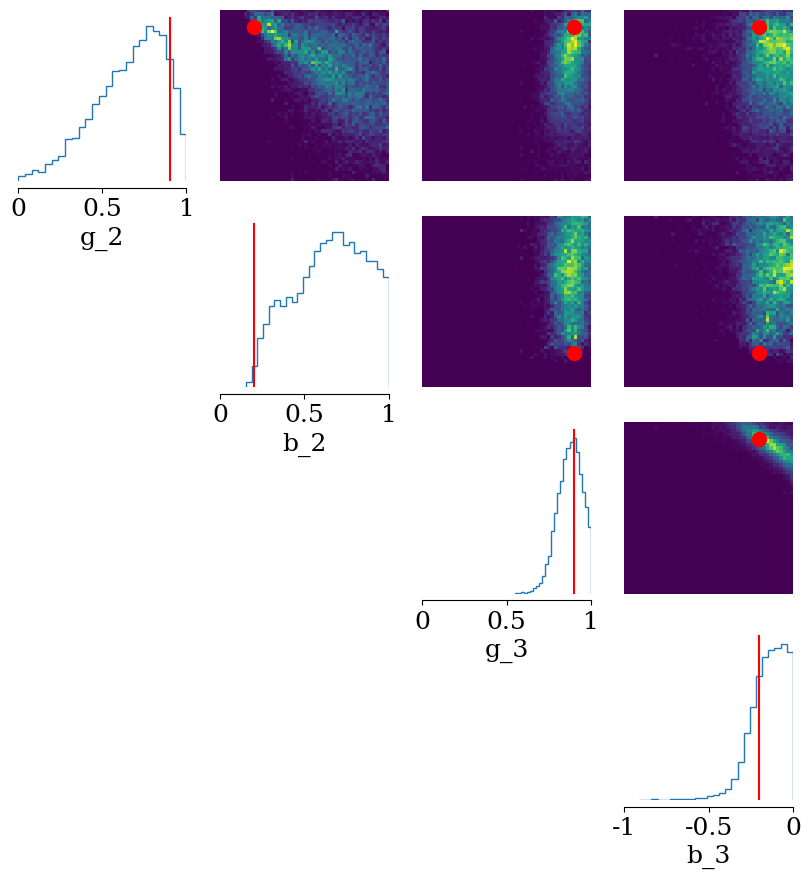

In [47]:
bh_smooth = np.loadtxt("../../exp_dir/brockhommes_smooth/resnet_100000/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(bh_smooth, limits=[[0,1], [0,1], [0,1], [-1, 0]], points=[np.array([0.9,0.2,0.9,-0.2])],
                      points_colors='r', labels=["g_2", "b_2", "g_3", "b_3"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

plt.savefig("./overleaf_plots/bh_smooth_resnet_100000.png", dpi=1000, format='png', bbox_inches='tight')

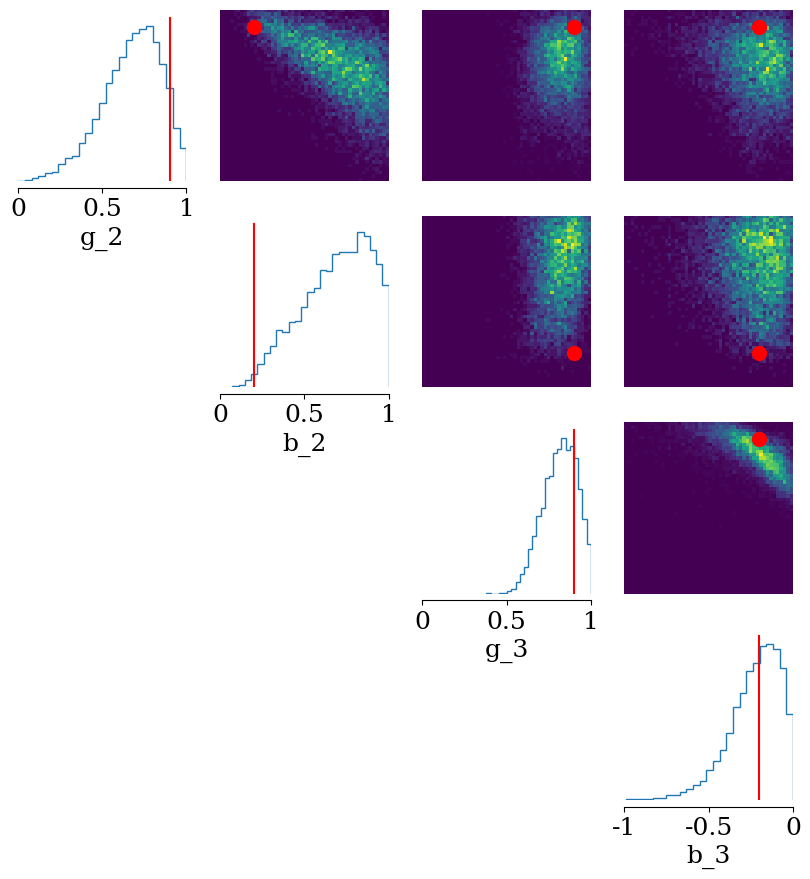

In [4]:
bh_smooth = np.loadtxt("../../exp_dir/brockhommes_smooth/maf_100000/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(bh_smooth, limits=[[0,1], [0,1], [0,1], [-1, 0]], points=[np.array([0.9,0.2,0.9,-0.2])],
                      points_colors='r', labels=["g_2", "b_2", "g_3", "b_3"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

plt.savefig("./overleaf_plots/bh_smooth_maf_100000.png", dpi=1000, format='png', bbox_inches='tight')

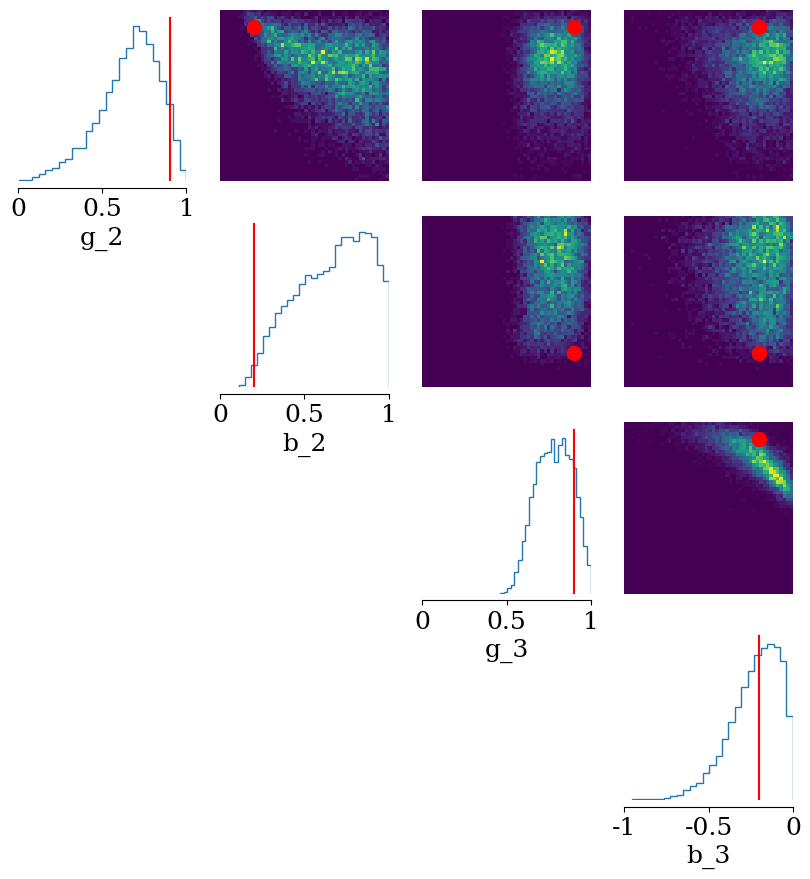

In [4]:
# new arch -> maf_s
bh_smooth = np.loadtxt("../../exp_dir/brockhommes_smooth/1715592127.0847654/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(bh_smooth, limits=[[0,1], [0,1], [0,1], [-1, 0]], points=[np.array([0.9,0.2,0.9,-0.2])],
                      points_colors='r', labels=["g_2", "b_2", "g_3", "b_3"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

plt.savefig("./overleaf_plots/bh_smooth_maf_100000.png", dpi=1000, format='png', bbox_inches='tight')

# MAP

In [19]:
from sbi4abm.utils import io

bh_smooth_f = io.load_task('bh_smooth')

file_name = "maf_100000"
with open(f"../../exp_dir/brockhommes_smooth/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [20]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()

In [21]:
from scipy.optimize import minimize

# observed data
observation_strategy_1 = 2.09889679e-06  
observation_strategy_2 = 9.27660781e-01
observation_strategy_3 = 5.71292115e-04
observation_strategy_4 = 7.17658282e-02
observations = torch.tensor([observation_strategy_1, observation_strategy_2, observation_strategy_3, observation_strategy_4])
print(observations)

initial_theta = bh_smooth_f[1].mean.numpy()

# Optimize to find the MAP estimate
result = minimize(neg_log_posterior, initial_theta, args=(posterior, observations), method='L-BFGS-B')
map_estimate = result.x

print(f"MAP estimate: {map_estimate}")

tensor([2.0989e-06, 9.2766e-01, 5.7129e-04, 7.1766e-02])


/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


MAP estimate: [ 0.5  0.5  0.5 -0.5]


In [22]:
true_theta = torch.tensor(bh_smooth_f[3])
map_estimate = torch.tensor(map_estimate)
print(true_theta)
print(map_estimate)
loss = F.mse_loss(map_estimate, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([ 0.9000,  0.2000,  0.9000, -0.2000], dtype=torch.float64)
tensor([ 0.5000,  0.5000,  0.5000, -0.5000], dtype=torch.float64)
Loss between mean theta and true theta: 0.125


In [23]:
y_star = bh_smooth_f[0](map_estimate.tolist())
y_star = torch.tensor([y_star[-1][0], y_star[-1][1], y_star[-1][2], y_star[-1][3]])
print(y_star)

tensor([6.0655e-04, 1.0276e-06, 9.9768e-01, 1.7076e-03], dtype=torch.float64)


In [24]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)

print(observations)
print(y_star)

# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss between s(y_star) and s(y): {loss.item()}")

tensor([2.0989e-06, 9.2766e-01, 5.7129e-04, 7.1766e-02])
tensor([6.0655e-04, 1.0276e-06, 9.9768e-01, 1.7076e-03], dtype=torch.float64)
Loss between s(y_star) and s(y): 0.46492411202363404


# Mean

In [14]:
# Generate samples from the posterior
num_samples = 1000  # Number of samples to draw
posterior_samples = posterior.sample((num_samples,), x=observations)

# Compute the mean of the samples
mean_estimate = posterior_samples.mean(dim=0)
print(f"Mean estimate: {mean_estimate}")

Drawing 1000 posterior samples: 10224it [00:00, 50458.03it/s]           

Mean estimate: tensor([ 0.6409,  0.6204,  0.6916, -0.2268])


In [15]:
# Compute statistics about the sampled theta values
posterior_samples_np = posterior_samples.numpy()
mean_theta = np.mean(posterior_samples_np, axis=0)
std_theta = np.std(posterior_samples_np, axis=0)
lower_bound_theta = np.percentile(posterior_samples_np, 2.5, axis=0)
upper_bound_theta = np.percentile(posterior_samples_np, 97.5, axis=0)

print(f"Mean of theta: {mean_theta}")
print(f"Standard deviation of theta: {std_theta}")
print(f"95% credible interval for theta: [{lower_bound_theta}, {upper_bound_theta}]")

Mean of theta: [ 0.6409291   0.62042844  0.6916131  -0.2268306 ]
Standard deviation of theta: [0.21392514 0.21009004 0.21572316 0.1487382 ]
95% credible interval for theta: [[ 0.18304386  0.22450205  0.20222291 -0.56923051], [ 0.95676584  0.9657814   0.98343557 -0.02227858]]


In [16]:
true_theta = torch.tensor(bh_smooth_f[3])
mean_theta = torch.tensor(mean_theta)
print(true_theta)
print(mean_theta)
loss = F.mse_loss(mean_theta, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([ 0.9000,  0.2000,  0.9000, -0.2000], dtype=torch.float64)
tensor([ 0.6409,  0.6204,  0.6916, -0.2268])
Loss between mean theta and true theta: 0.07200569894247054


In [17]:
y_star = bh_smooth_f[0](mean_estimate.tolist())
y_star = torch.tensor([y_star[-1][0], y_star[-1][1], y_star[-1][2], y_star[-1][3]])

print(y_star)
print(observations)

tensor([2.5371e-14, 1.0000e+00, 4.2387e-18, 5.0841e-13], dtype=torch.float64)
tensor([2.0989e-06, 9.2766e-01, 5.7129e-04, 7.1766e-02])


In [18]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss between s(y_star) and s(y): {loss.item()}")

Loss between s(y_star) and s(y): 0.0025959063025858932


# Posterior Predictive Checks 

In [103]:
from sbi4abm.utils import io

bh_smooth_f = io.load_task('bh_smooth')

In [104]:
idxs = np.random.randint(bh_smooth.shape[0], size=1000)

### Posterior Predictives

In [105]:
pps = []
for idx in idxs:
    data = bh_smooth_f[0](list(bh_smooth[idx]))
    pps.append(data)

In [106]:
posterior_strategy_1 = []
posterior_strategy_2 = []
posterior_strategy_3 = []
posterior_strategy_4 = []

for pp in pps:
    if isinstance(pp, torch.Tensor):
        pp = pp.detach().cpu().numpy()

    final_state = pp[-1]
    posterior_strategy_1.append(final_state[0])
    posterior_strategy_2.append(final_state[1])
    posterior_strategy_3.append(final_state[2])
    posterior_strategy_4.append(final_state[3])

### Prior Predictives

In [107]:
pps_ = []
for idx in idxs:
    data = bh_smooth_f[0](list(bh_smooth_f[1].sample().tolist()))
    pps_.append(data)

In [108]:
prior_strategy_1 = []
prior_strategy_2 = []
prior_strategy_3 = []
prior_strategy_4 = []

for pp in pps_:
    if isinstance(pp, torch.Tensor):
        pp = pp.detach().cpu().numpy()

    final_state = pp[-1]
    prior_strategy_1.append(final_state[0])
    prior_strategy_2.append(final_state[1])
    prior_strategy_3.append(final_state[2])
    prior_strategy_4.append(final_state[3])

### Observation

In [109]:
final = bh_smooth_f[2]

observation_strategy_1 = 2.09889679e-06  
observation_strategy_2 = 9.27660781e-01
observation_strategy_3 = 5.71292115e-04
observation_strategy_4 = 7.17658282e-02

### Plots

In [110]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

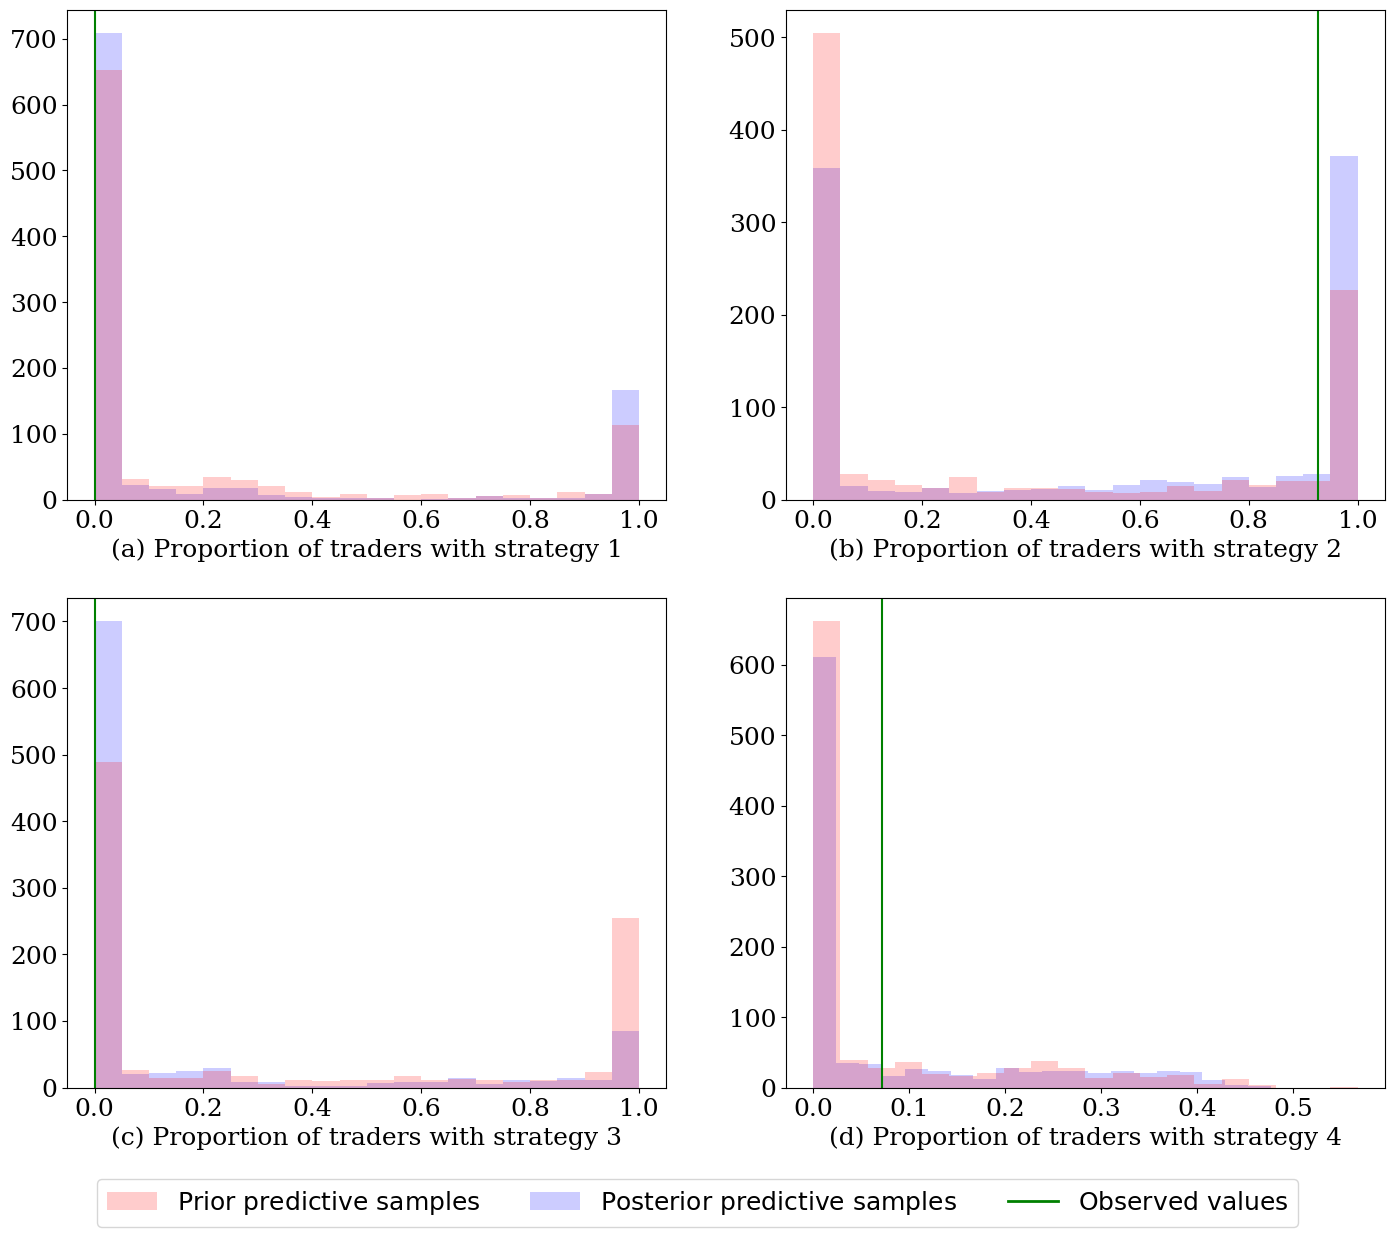

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(17,14))

axes[0, 0].hist(posterior_strategy_1, bins=20, color='b', alpha=0.2)
axes[0, 0].hist(prior_strategy_1, bins=20, color='r', alpha=0.2)
axes[0, 0].axvline(observation_strategy_1, c='g')
axes[0, 0].set_xlabel(r"(a) Proportion of traders with strategy 1", fontsize=18)

axes[0, 1].hist(posterior_strategy_2, bins=20, color='b', alpha=0.2)
axes[0, 1].hist(prior_strategy_2, bins=20, color='r', alpha=0.2)
axes[0, 1].axvline(observation_strategy_2, c='g')
axes[0, 1].set_xlabel(r"(b) Proportion of traders with strategy 2", fontsize=18)

axes[1, 0].hist(posterior_strategy_3, bins=20, color='b', alpha=0.2)
axes[1, 0].hist(prior_strategy_3, bins=20, color='r', alpha=0.2)
axes[1, 0].axvline(observation_strategy_3, c='g')
axes[1, 0].set_xlabel(r"(c) Proportion of traders with strategy 3", fontsize=18)
                             
axes[1, 1].hist(posterior_strategy_4, bins=20, color='b', alpha=0.2)
axes[1, 1].hist(prior_strategy_4, bins=20, color='r', alpha=0.2)
axes[1, 1].axvline(observation_strategy_4, c='g')
axes[1, 1].set_xlabel(r"(d) Proportion of traders with strategy 4", fontsize=18)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18)

# plt.savefig("./overleaf_plots/graph_posterior_predictives.png", dpi=1000, format='png', bbox_inches='tight')

# Sensitivity Analysis

In [11]:
file_name = "maf_100000"
with open(f"../../exp_dir/brockhommes_smooth/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

Drawing 200 posterior samples: 8817it [00:07, 1107.11it/s]                      


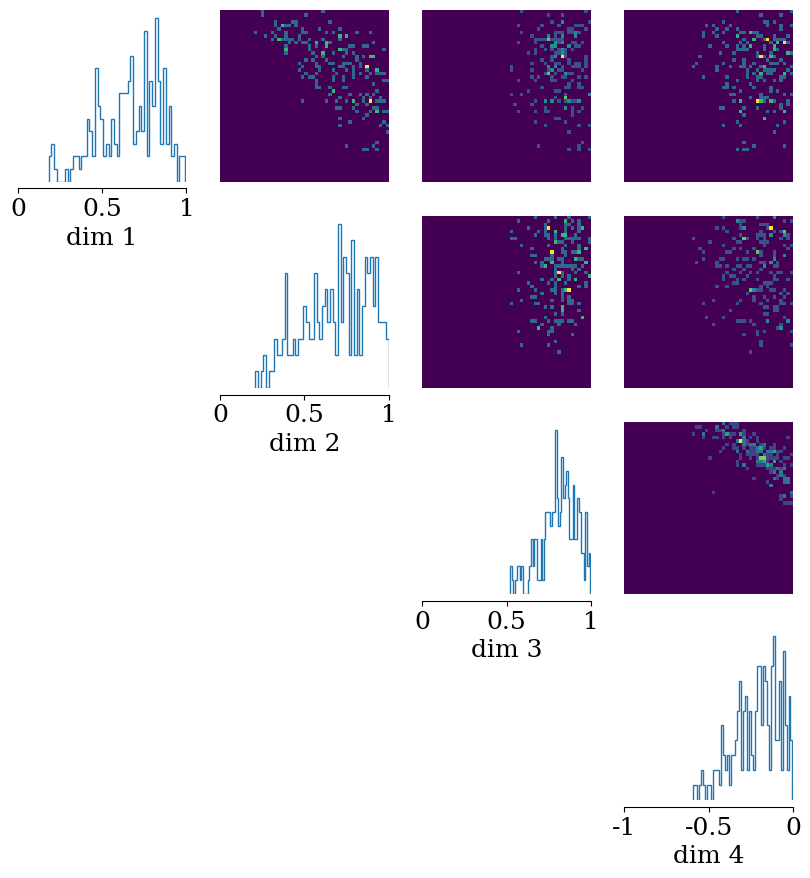

In [13]:
from sbi4abm.sbi.analysis import ActiveSubspace, pairplot

posterior_samples = posterior.sample((200,))
_ = pairplot(posterior_samples, limits=[[0,1], [0,1], [0,1], [-1, 0]], figsize=(10, 10))

In [14]:
sensitivity = ActiveSubspace(posterior)
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Drawing 1000 posterior samples: 9563it [00:06, 1386.41it/s]                        


Eigenvalues: 
 tensor([1.2406e-06, 3.4578e-06, 9.6323e-06, 3.5467e-05]) 

Eigenvectors: 
 tensor([[ 0.5020, -0.1540, -0.8506,  0.0253],
        [-0.8647, -0.0945, -0.4933, -0.0037],
        [-0.0108, -0.5440,  0.1168,  0.8309],
        [-0.0125,  0.8194, -0.1392,  0.5559]])
